In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [2]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Convolution2D,BatchNormalization,ReLU,LeakyReLU,Add,Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D

In [4]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
NUM_CLASSES = 4
INPUT_HEIGHT = 224
INPUT_WIDTH = 224
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
BATCH_SIZE = 32
MIXED_PRECISION = True
SHUFFLE = True

# Mixed-precision setting
if MIXED_PRECISION:
    policy = keras.mixed_precision.Policy("mixed_float16")
    keras.mixed_precision.set_global_policy(policy)

Shape of the TIFF stack: (1600, 224, 224, 3)
[[[13.060997    0.22100067 -6.6800003 ]
  [13.060997    0.22100067 -6.6800003 ]
  [20.060997    7.2210007   0.3199997 ]
  ...
  [34.060997   21.221      14.32      ]
  [34.060997   21.221      14.32      ]
  [36.060997   23.221      16.32      ]]

 [[13.060997    0.22100067 -6.6800003 ]
  [13.060997    0.22100067 -6.6800003 ]
  [20.060997    7.2210007   0.3199997 ]
  ...
  [34.060997   21.221      14.32      ]
  [34.060997   21.221      14.32      ]
  [36.060997   23.221      16.32      ]]

 [[18.060997    5.2210007  -1.6800003 ]
  [18.060997    5.2210007  -1.6800003 ]
  [19.060997    6.2210007  -0.6800003 ]
  ...
  [21.060997    8.221001    1.3199997 ]
  [21.060997    8.221001    1.3199997 ]
  [24.060997   11.221001    4.3199997 ]]

 ...

 [[27.060997   14.221001    7.3199997 ]
  [27.060997   14.221001    7.3199997 ]
  [11.060997   -1.7789993  -8.68      ]
  ...
  [23.060997   10.221001    3.3199997 ]
  [23.060997   10.221001    3.3199997 ]

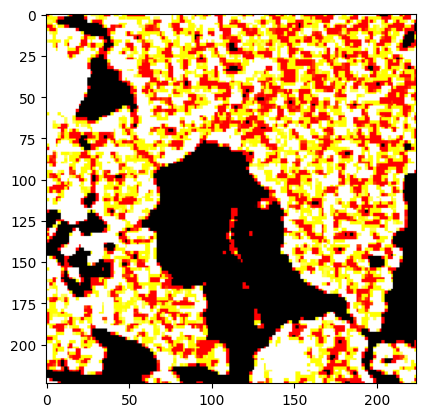

In [7]:

import skimage.io as io
from skimage import transform
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/images_as_128x128_patches.tif'

train_images = io.imread(stack_path)

resized_train_images = []
for image in train_images:
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
    rgb_image = np.stack([resized_image] * 3, axis=-1)
    image = keras.applications.vgg16.preprocess_input(rgb_image)
    resized_train_images.append(image)

train_images = np.array(resized_train_images)

print("Shape of the TIFF stack:", train_images.shape)
plt.imshow(train_images[0])

print(train_images[0])

Shape of the TIFF stack: (1600, 224, 224)
[1 2 3 4]


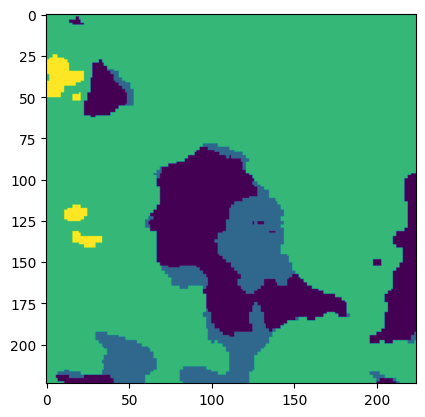

In [8]:
stack_path = '/content/gdrive/MyDrive/sandstone_data_for_ML/full_labels_for_deep_learning/128_patches/masks_as_128x128_patches.tif'
train_masks = io.imread(stack_path)

resized_train_masks = []
for image in train_masks:
    resized_image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_NEAREST)
    resized_train_masks.append(resized_image)

train_masks = np.array(resized_train_masks)

print("Shape of the TIFF stack:", train_masks.shape)

plt.imshow(train_masks[0])
print(np.unique(train_masks[0]))

In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
print(n, h, w)
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
np.unique(train_masks_encoded_original_shape)

1600 224 224


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [10]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)

(1600, 224, 224, 1)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1440, 224, 224, 3)
(160, 224, 224, 3)
(1440, 224, 224, 1)
(160, 224, 224, 1)


In [12]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [13]:
# Categorical encoding
from keras.utils import to_categorical
n_classes=4
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [14]:
print(y_train.shape)

(1440, 224, 224, 1)


In [15]:
# Class weights to handle class imbalance
class_labels = np.unique(train_masks_reshaped_encoded)
class_counts = [np.sum(train_masks_reshaped_encoded == label) for label in class_labels]
total_samples = len(train_masks_reshaped_encoded)
class_weights = total_samples / (len(class_labels) * np.array(class_counts))

# Print the calculated class weights
print("Class Weights:", class_weights)

Class Weights: [1.93327605 3.07488286 0.32786091 9.30632405]


# Defining the model (ReSeg:)



In [16]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

In [17]:
import tensorflow as tf

class ReNet(tf.keras.Model):
    def __init__(self, n_input, n_units, patch_size=(1, 1)):
        super(ReNet, self).__init__()

        self.patch_size_height = int(patch_size[0])
        self.patch_size_width = int(patch_size[1])

        assert self.patch_size_height >= 1
        assert self.patch_size_width >= 1

        self.tiling = False if ((self.patch_size_height == 1) and (self.patch_size_width == 1)) else True

        self.rnn_hor = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))
        self.rnn_ver = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(n_units, return_sequences=True))

    def tile(self, x):
        n_height_padding = self.patch_size_height - x.shape[2] % self.patch_size_height
        n_width_padding = self.patch_size_width - x.shape[3] % self.patch_size_width

        n_top_padding = n_height_padding // 2
        n_bottom_padding = n_height_padding - n_top_padding

        n_left_padding = n_width_padding // 2
        n_right_padding = n_width_padding - n_left_padding

        x = tf.pad(x, [[0, 0], [n_top_padding, n_bottom_padding], [n_left_padding, n_right_padding], [0, 0]])

        b, n_filters, n_height, n_width = x.shape

        assert n_height % self.patch_size_height == 0
        assert n_width % self.patch_size_width == 0

        new_height = n_height // self.patch_size_height
        new_width = n_width // self.patch_size_width

        x = tf.reshape(x, (b, n_filters, new_height, self.patch_size_height, new_width, self.patch_size_width))
        x = tf.transpose(x, (0, 2, 4, 1, 3, 5))
        x = tf.reshape(x, (b, new_height, new_width, self.patch_size_height * self.patch_size_width * n_filters))
        x = tf.transpose(x, (0, 3, 1, 2))

        return x

    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']

        b, n_height, n_width, n_filters = x.shape

        x = tf.reshape(x, (b * n_height, n_width, n_filters))
        if hor_or_ver == 'hor':
            x = self.rnn_hor(x)
        else:
            x = self.rnn_ver(x)
        x = tf.reshape(x, (b, n_height, n_width, -1))

        return x

    def call(self, x):
        if self.tiling:
            x = self.tile(x)
        x = tf.transpose(x, (0, 2, 3, 1))
        x = self.rnn_forward(x, 'hor')
        x = tf.transpose(x, (0, 2, 1, 3))
        x = self.rnn_forward(x, 'ver')
        x = tf.transpose(x, (0, 2, 1, 3))
        x = tf.transpose(x, (0, 3, 1, 2))

        return x

class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()

        vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))
        self.model = tf.keras.Sequential(vgg16.layers[:-5])

    def call(self, x):
        x = self.model(x)

        return x

class ReSeg(tf.keras.Model):
    def __init__(self, n_classes):
        super(ReSeg, self).__init__()

        self.n_classes = n_classes

        self.cnn = CNN()
        self.renet1 = ReNet(256, 10)
        self.renet2 = ReNet(100 * 2, 25)
        self.upsampling1 = tf.keras.layers.Conv2DTranspose(50, kernel_size=(2, 2), strides=(2, 2))
        self.relu1 = tf.keras.layers.Activation('tanh')
        self.upsampling2 = tf.keras.layers.Conv2DTranspose(50, kernel_size=(2, 2), strides=(2, 2))
        self.relu2 = tf.keras.layers.Activation('tanh')
        self.output_layer = tf.keras.layers.Conv2D(self.n_classes, kernel_size=(1, 1), strides=(1, 1))

    def call(self, x):
        x = self.cnn(x)
        x = self.renet1(x)
        x = self.renet2(x)
        x = self.relu1(self.upsampling1(x))
        x = self.relu2(self.upsampling2(x))
        x = self.output_layer(x)
        x = tf.image.resize(x, size=(224, 224), method=tf.image.ResizeMethod.BILINEAR)

        return x

model = ReSeg(n_classes=4)
model.build(input_shape=(1, 224, 224, 3))
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "re_seg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn (CNN)                   multiple                  7635264   
                                                                 
 re_net (ReNet)              multiple                  4320      
                                                                 
 re_net_1 (ReNet)            multiple                  18600     
                                                                 
 conv2d_transpose (Conv2DTr  multiple                  102450    
 anspose)                                                        
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 conv2d_transpose_1 (Conv2D  multiple                  10050 

In [18]:
X_train.shape

(1440, 224, 224, 3)

In [19]:
#model.call(np.array([X_train[0]]))

In [20]:
fcn32s_optimizer = keras.optimizers.SGD(learning_rate=0.001)
fcn32s_loss = keras.losses.CategoricalCrossentropy()

# Maintain mIOU and Pixel-wise Accuracy as metrics
model.compile(
    optimizer=fcn32s_optimizer,
    loss=fcn32s_loss,
    metrics=[
        'accuracy',
    ],
)


In [21]:
print(X_train.shape, y_train_cat.shape, X_test.shape, y_test_cat.shape)

(1440, 224, 224, 3) (1440, 224, 224, 4) (160, 224, 224, 3) (160, 224, 224, 4)


In [22]:
X_train = X_train[0:50]
y_train_cat = y_train_cat[0:50]
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=1, validation_data=(X_test, y_test_cat))

Epoch 1/10
50/50 [==============================] - 39s 289ms/step - loss: 2.8633 - accuracy: 0.2464 - val_loss: 1.0026 - val_accuracy: 0.0401
Epoch 2/10
50/50 [==============================] - 9s 177ms/step - loss: 0.9514 - accuracy: 0.0633 - val_loss: 0.9384 - val_accuracy: 0.0883
Epoch 3/10
50/50 [==============================] - 8s 166ms/step - loss: 0.8817 - accuracy: 0.0620 - val_loss: 0.8509 - val_accuracy: 0.0534
Epoch 4/10
50/50 [==============================] - 14s 282ms/step - loss: 0.8726 - accuracy: 0.0673 - val_loss: 0.8396 - val_accuracy: 0.0515
Epoch 5/10
50/50 [==============================] - 9s 175ms/step - loss: 0.8579 - accuracy: 0.0425 - val_loss: 0.8808 - val_accuracy: 0.0404
Epoch 6/10
50/50 [==============================] - 8s 164ms/step - loss: 0.8474 - accuracy: 0.0357 - val_loss: 0.8427 - val_accuracy: 0.0455
Epoch 7/10
50/50 [==============================] - 9s 180ms/step - loss: 0.8280 - accuracy: 0.0359 - val_loss: 0.8268 - val_accuracy: 0.0433
Epoc

In [23]:
print(X_test.shape, y_test_cat.shape)

metrics = model.evaluate(X_test, y_test_cat, batch_size=1)
print(metrics)
print("Accuracy is = ", (metrics[1] * 100.0), "%")

(160, 224, 224, 3) (160, 224, 224, 4)
160/160 [==============================] - 5s 33ms/step - loss: 0.8056 - accuracy: 0.0380
[0.8056138157844543, 0.03802378103137016]
Accuracy is =  3.8023781031370163 %


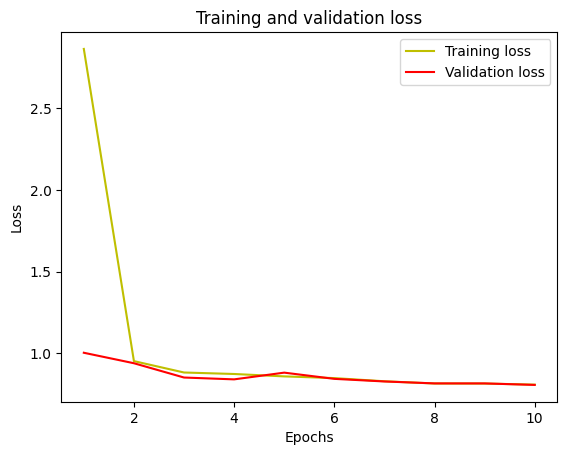

{'loss': [2.863339424133301, 0.9514091610908508, 0.8816525936126709, 0.8725694417953491, 0.8578675985336304, 0.847410261631012, 0.8279544115066528, 0.8142997026443481, 0.8140260577201843, 0.807426929473877], 'accuracy': [0.24641501903533936, 0.06333027780056, 0.06202407553792, 0.06730668246746063, 0.042466916143894196, 0.03568638488650322, 0.03591637313365936, 0.03429567813873291, 0.04378547519445419, 0.031709183007478714], 'val_loss': [1.0026013851165771, 0.9384095072746277, 0.8508899807929993, 0.8396293520927429, 0.880826473236084, 0.842715859413147, 0.8267667889595032, 0.8149396777153015, 0.8148362040519714, 0.8056138157844543], 'val_accuracy': [0.04012899473309517, 0.08828498423099518, 0.05338682979345322, 0.051509685814380646, 0.040418725460767746, 0.0454927422106266, 0.0432518795132637, 0.03961704671382904, 0.03877027705311775, 0.03802378103137016]}


In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(history.history)

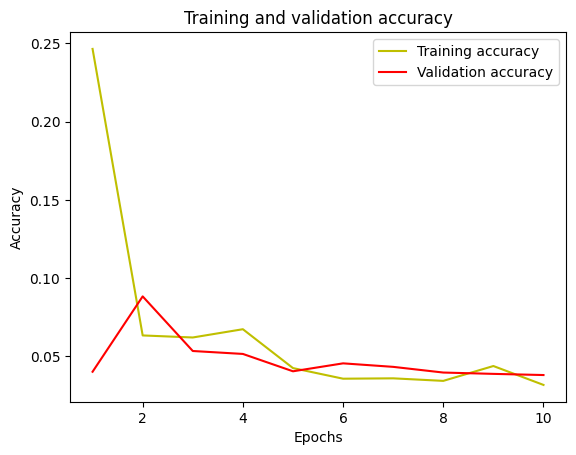

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
from scipy.ndimage import rotate
def apply_random_rotation(image, mask):
    angle = np.random.uniform(0, 180)
    rotated_image = rotate(image, angle, reshape=False, mode='reflect')
    rotated_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        rotated_channel = rotate(mask[..., channel], angle, reshape=False, mode='reflect')
        rotated_mask[..., channel] = (rotated_channel > 0.5).astype(np.float32)
    return rotated_image, rotated_mask

In [27]:
def apply_horizontal_flip(image, mask):
    flipped_image = np.fliplr(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.fliplr(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [28]:
def apply_vertical_flip(image, mask):
    flipped_image = np.flipud(image)
    flipped_mask = np.zeros_like(mask)
    for channel in range(mask.shape[-1]):
        flipped_channel = np.flipud(mask[..., channel])
        flipped_mask[..., channel] = flipped_channel
    return flipped_image, flipped_mask

In [29]:
augmented_image, augmented_mask = apply_vertical_flip(X_train[0], y_train_cat[0])
print("Image Shape: ", augmented_image.shape)
print("Mask Shape: ", augmented_mask.shape)

Image Shape:  (224, 224, 3)
Mask Shape:  (224, 224, 4)


In [30]:
augmented_images = []
augmented_masks = []
for i in range(X_train.shape[0]):
    rot_img, rot_mask = apply_random_rotation(X_train[i], y_train_cat[i])
    h_flip_img, h_flip_mask = apply_horizontal_flip(X_train[i], y_train_cat[i])
    v_flip_img, v_flip_mask = apply_vertical_flip(X_train[i], y_train_cat[i])

    augmented_images.append(rot_img)
    augmented_images.append(h_flip_img)
    augmented_images.append(v_flip_img)

    augmented_masks.append(rot_mask)
    augmented_masks.append(h_flip_mask)
    augmented_masks.append(v_flip_mask)

augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
print("Aug Image Shape: ", augmented_images.shape)
print("Aug Mask Shape: ", augmented_masks.shape)

Aug Image Shape:  (150, 224, 224, 3)
Aug Mask Shape:  (150, 224, 224, 4)


In [31]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train_cat, augmented_masks), axis = 0)

#y_train_aug = np.argmax(y_train_aug, axis=-1)
#y_train_aug = y_train_aug[..., np.newaxis]

print("Full Aug Image Shape: ", X_train_aug.shape)
print("Full Aug Mask Shape: ", y_train_aug.shape)

print(y_test.shape, X_test.shape)

Full Aug Image Shape:  (200, 224, 224, 3)
Full Aug Mask Shape:  (200, 224, 224, 4)
(160, 224, 224, 1) (160, 224, 224, 3)


In [32]:
# Increasing the number of epochs from 50 ==> 100
# Using the augmented dataset of images and masks
history_aug = model.fit(X_train_aug, y_train_aug,
                    verbose=1,
                        batch_size=1,
                    epochs=20,
                    validation_data=(X_test, y_test_cat),
                    shuffle=False)

Epoch 1/20
200/200 [==============================] - 21s 106ms/step - loss: 0.7921 - accuracy: 0.0343 - val_loss: 1.1360 - val_accuracy: 0.0351
Epoch 2/20
200/200 [==============================] - 20s 102ms/step - loss: 0.8116 - accuracy: 0.0412 - val_loss: 1.0948 - val_accuracy: 0.0351
Epoch 3/20
200/200 [==============================] - 21s 106ms/step - loss: 0.7461 - accuracy: 0.0288 - val_loss: 0.9933 - val_accuracy: 0.0351
Epoch 4/20
200/200 [==============================] - 21s 106ms/step - loss: 4.9935 - accuracy: 0.0288 - val_loss: 8.6107 - val_accuracy: 0.0351
Epoch 5/20
200/200 [==============================] - 20s 103ms/step - loss: 10.6089 - accuracy: 0.0288 - val_loss: 12.0578 - val_accuracy: 0.0351
Epoch 6/20
200/200 [==============================] - 22s 108ms/step - loss: 12.7795 - accuracy: 0.0288 - val_loss: 13.2257 - val_accuracy: 0.0351
Epoch 7/20
200/200 [==============================] - 26s 129ms/step - loss: 13.5876 - accuracy: 0.0288 - val_loss: 13.7523 - 

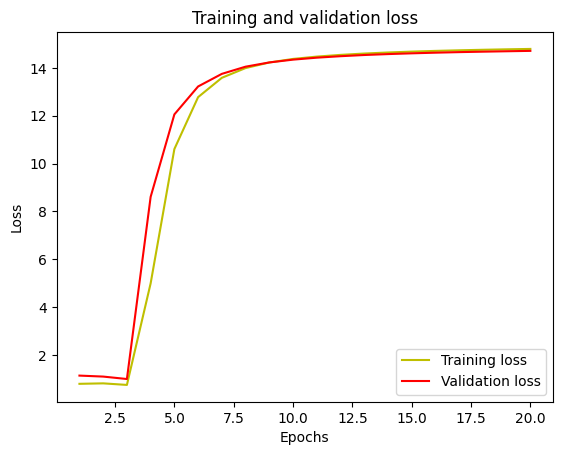

In [33]:
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

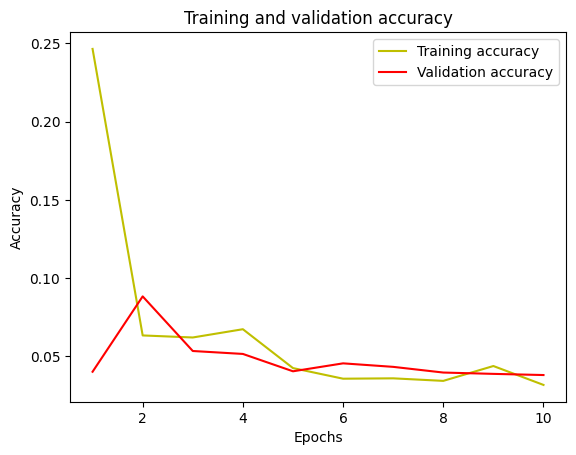

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Comparitive analysis of evaluation metrics of the models on the sandstone dataset

5/5 [==============================] - 10s 101ms/step


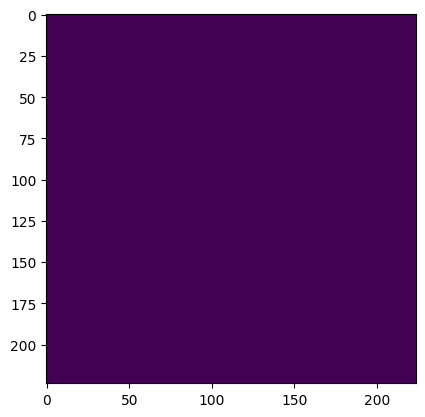

In [35]:
# prediction on training set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

plt.imshow(y_pred_argmax[0])

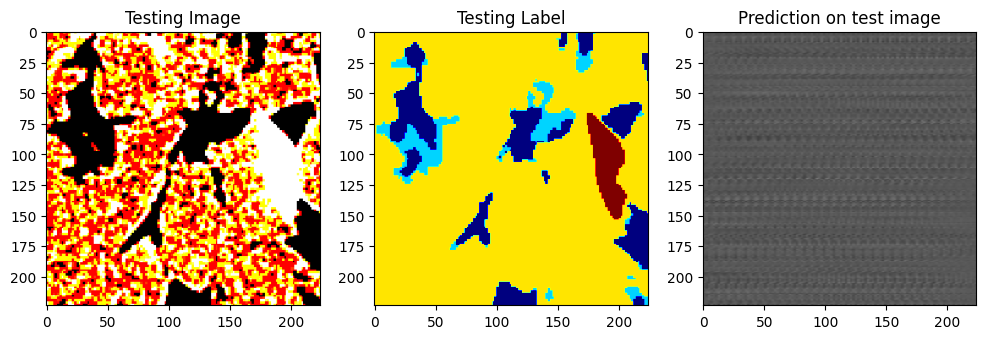

In [47]:
test_img = X_test[5]
ground_truth = y_test[5]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(y_pred[5], cmap='jet')
plt.show()

In [48]:
print("true: ", y_test_cat.shape)
print("pred: ", y_pred.shape)

true:  (160, 224, 224, 4)
pred:  (160, 224, 224, 4)


In [49]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

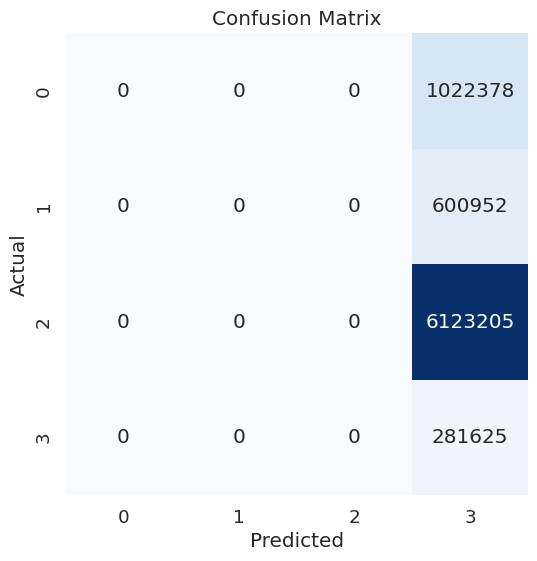

In [50]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_test, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 3.51%


In [52]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_test, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 4%


In [53]:
# recall
def classwise_recall(y_test, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 100%


In [54]:
# f1-score
def classwise_f1_score(y_test, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_test, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 100%


In [55]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.008769911


In [56]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[      0.       0.       0. 1022378.]
 [      0.       0.       0.  600952.]
 [      0.       0.       0. 6123205.]
 [      0.       0.       0.  281625.]]
IoU for class1 is:  0.0
IoU for class2 is:  0.0
IoU for class3 is:  0.0
IoU for class4 is:  0.035079643


Training Set

In [59]:
# prediction on training set
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

5/5 [==============================] - 1s 133ms/step


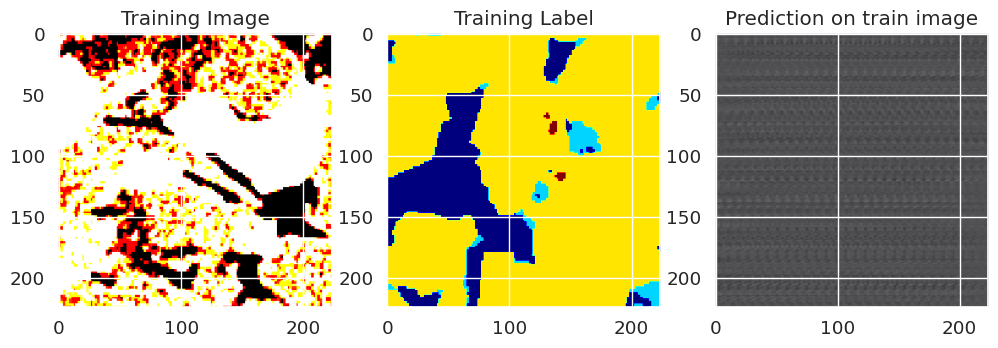

In [60]:
import random
train_img_number = random.randint(0, len(X_train))



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Training Image')
plt.imshow(X_test[train_img_number], cmap='gray')
plt.subplot(232)
plt.title('Training Label')
plt.imshow(y_train[train_img_number], cmap='jet')
plt.subplot(233)
plt.title('Prediction on train image')
plt.imshow(y_pred[train_img_number], cmap='jet')
plt.show()

In [61]:
print("true: ", y_train_cat.shape)
print("pred: ", y_pred.shape)

true:  (50, 224, 224, 4)
pred:  (160, 224, 224, 4)


In [62]:
# Converting masks to one channel format with values 0, 1, 2 and 3
y_pred_img = np.argmax(y_pred, axis=3)

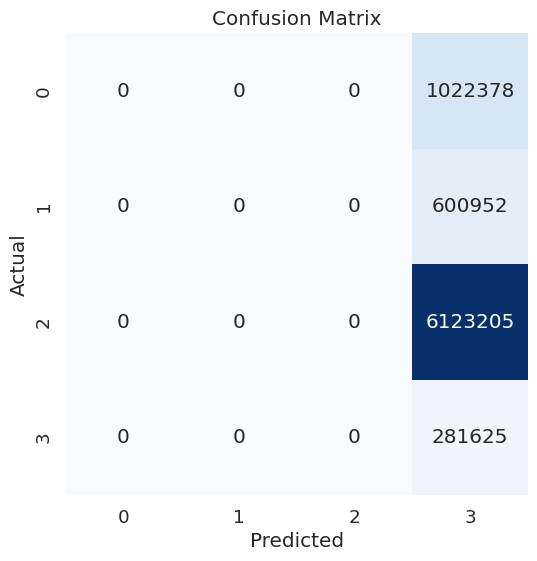

In [65]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test.flatten(), y_pred_img.flatten())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size if needed
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', square=True,
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [66]:
# Pix Accuracy
def accuracy(gnd, pred):
    gnd_flat = gnd.flatten()
    pred_flat = pred.flatten()
    matching_pixels = np.sum(gnd_flat == pred_flat)
    total_pixels = gnd_flat.shape[0]
    accuracy = matching_pixels / total_pixels
    return accuracy

print(f"Pixel wise accuracy: {round(accuracy(y_train, y_pred_img)*100, 2)}%")

Pixel wise accuracy: 0.0%


<ipython-input-66-3689c83f910d>:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  matching_pixels = np.sum(gnd_flat == pred_flat)


In [68]:
# precision
from sklearn.metrics import precision_score, recall_score, f1_score

def classwise_precision(y_train, y_pred_img, num_classes):
    precision = np.zeros(num_classes)
    for i in range(num_classes):
        precision[i] = precision_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return precision
prec_classes = classwise_precision(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(prec_classes[0]*100)}%")
print(f"Class 1 precision: {round(prec_classes[1]*100)}%")
print(f"Class 2 precision: {round(prec_classes[2]*100)}%")
print(f"Class 3 precision: {round(prec_classes[3]*100)}%")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 4%


In [70]:
# recall
def classwise_recall(y_train, y_pred_img, num_classes):
    recall = np.zeros(num_classes)
    for i in range(num_classes):
        recall[i] = recall_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return recall

rec_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(rec_classes[0]*100)}%")
print(f"Class 1 precision: {round(rec_classes[1]*100)}%")
print(f"Class 2 precision: {round(rec_classes[2]*100)}%")
print(f"Class 3 precision: {round(rec_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 100%


In [71]:
# f1-score
def classwise_f1_score(y_train, y_pred_img, num_classes):
    f1_scores = np.zeros(num_classes)
    for i in range(num_classes):
        f1_scores[i] = f1_score((y_test == i).flatten(), (y_pred_img == i).flatten())
    return f1_scores

f1_classes = classwise_recall(y_train, y_pred_img, 4)
print(f"Class 0 precision: {round(f1_classes[0]*100)}%")
print(f"Class 1 precision: {round(f1_classes[1]*100)}%")
print(f"Class 2 precision: {round(f1_classes[2]*100)}%")
print(f"Class 3 precision: {round(f1_classes[3]*100)}%")

Class 0 precision: 0%
Class 1 precision: 0%
Class 2 precision: 0%
Class 3 precision: 100%


In [72]:
# mean iou
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.008769911


In [73]:
# Classwise iou
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

[[      0.       0.       0. 1022378.]
 [      0.       0.       0.  600952.]
 [      0.       0.       0. 6123205.]
 [      0.       0.       0.  281625.]]
IoU for class1 is:  0.0
IoU for class2 is:  0.0
IoU for class3 is:  0.0
IoU for class4 is:  0.035079643
